<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Abnomaly_detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6

In [2]:
!pip install pyod

     |████████████████████████████████| 102kB 4.0MB/s 
     |████████████████████████████████| 2.1MB 7.5MB/s 
  Created wheel for pyod: filename=pyod-0.8.5-cp36-none-any.whl size=112038 sha256=5fe265493a7acd091bdb5c5d54ae8d8e0565fae339359b67a73bf8604a8cb848
  Stored in directory: /root/.cache/pip/wheels/f2/2d/37/2c099f1b61c7f47b6954ae429ffea7de5c897e84ec4b876cd2
  Created wheel for combo: filename=combo-0.1.2-cp36-none-any.whl size=42028 sha256=96fc9c217b0c7d6726d6db046052036ca4319fc5552633759d13205e0f83f520
  Stored in directory: /root/.cache/pip/wheels/01/d9/bf/d1a371a5f0844cd8a53c04c14daa89974c93f429dda9dceb86
  Created wheel for suod: filename=suod-0.0.4-cp36-none-any.whl size=2167158 sha256=cda96c6701554171066dee528454a7e22767caaa7f6fa19355f56b5554904b64
  Stored in directory: /root/.cache/pip/wheels/57/55/e5/a4fca65bba231f6d0115059b589148774b41faea25b3f2aa27
Successfully built pyod combo suod


In [3]:
import numpy as np
import pandas as pd
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data

In [4]:
contamination = 0.1  # percentage of outliers
n_train = 500  # number of training points
n_test = 500  # number of testing points
n_features = 25 # Number of features

X_train, y_train, X_test, y_test = generate_data(
    n_train=n_train, n_test=n_test,
    n_features= n_features, 
    contamination=contamination,random_state=1234)

/usr/local/lib/python3.6/dist-packages/pyod/utils/data.py:189: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)


In [6]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [7]:
print(X_train.shape,X_test.shape)

(500, 25) (500, 25)


In [8]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In [9]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
x_pca

,PC1,PC2
0,-1.374289,-0.290809
1,-1.430553,0.508865
2,-1.416714,1.039612
3,-1.158238,-0.018910
4,-0.874365,0.223768
...,...,...
495,12.494752,-3.779057
496,12.720427,0.451819
497,11.830232,-0.179812
498,10.370091,3.797218


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']

The purple points clustering together are the “normal” observations, and the yellow points are the outliers.

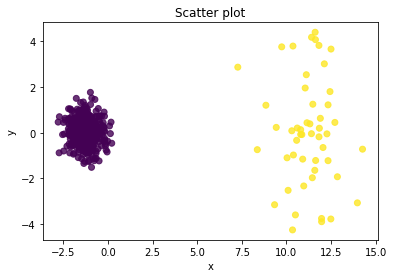

In [19]:
# Plot
import matplotlib.pyplot as plt
plt.scatter(x_pca["PC1"], x_pca["PC2"], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Model 1 

    Model 1: [25, 2, 2, 25]. The input layer and the output layer has 25 neurons each. There are two hidden layers, each has two neurons.

In [20]:
clf1 = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf1.fit(X_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                650       
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 5

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f7c9cc44488>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [ ]:
# Get the outlier scores for the train data
y_train_scores = clf1.decision_scores_  
y_train_scores

In [22]:
# Predict the anomaly scores
y_test_scores = clf1.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores

0       2.269521
1       2.787287
2       2.775147
3       2.932246
4       2.739236
         ...    
495    13.221239
496    16.189307
497    15.799958
498    13.040258
499    16.392447
Length: 500, dtype: float64

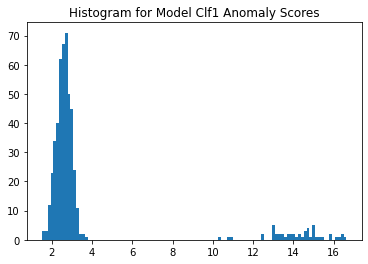

In [23]:
# Plot it!
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

if we use a histogram to count the frequency by the anomaly score, we will see the high scores corresponds to low frequency — the evidence of outliers. We choose 4.0 to be the cut point and those >=4.0 to be outliers.

In [24]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

0    450
1     50
Name: cluster, dtype: int64

In [26]:
df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,score,cluster
0,0.490850,0.599752,0.123036,0.124200,0.260621,0.535060,0.054199,-0.593279,0.820037,-0.050190,0.883886,0.107319,0.118136,0.565775,0.479314,0.369343,0.162560,0.083913,-0.344387,0.490514,0.848968,0.919533,1.162120,-0.651528,-0.138860,2.269521,0
1,0.953400,-0.669948,0.472268,0.141471,0.449857,0.154775,0.480871,-0.335910,-0.587196,0.809817,0.949703,-0.151841,-0.233898,0.200221,0.412201,-0.903222,-0.158045,1.072411,-0.317343,0.758364,-0.029758,0.332330,0.496692,-0.546290,0.953353,2.787287,0
2,-0.556078,0.498778,-0.344837,-0.287162,-0.043985,0.089953,0.499733,0.286055,1.407571,0.279362,0.132371,-0.066449,0.718918,0.413829,0.525852,0.293672,1.233307,-0.081703,0.849033,0.074216,-0.752306,0.167411,1.182533,0.495418,1.212759,2.775147,0
3,0.406306,0.563676,0.102176,0.843486,0.169333,1.066628,1.366840,0.286360,-0.598536,0.619118,0.868313,0.561261,-0.640273,0.528745,0.743536,0.756899,-0.022941,-0.493134,-0.085806,-0.247288,1.205646,-0.573057,0.988340,0.633948,0.586926,2.932246,0
4,0.113211,-0.131414,-0.428576,0.333657,0.511142,0.367135,0.848195,0.460072,0.069612,1.623246,0.824089,-0.266359,-0.133868,0.302390,0.084762,-0.680006,0.808684,0.520798,0.236163,0.881651,-1.025624,-0.053824,0.212217,-0.332923,0.201611,2.739236,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.458204,-1.480846,-1.627822,-0.128910,-4.662887,-1.095524,-2.854105,-1.497142,-1.821412,-0.714612,-1.523932,-2.759798,-3.310791,-3.218165,-2.359555,-0.679159,-1.035494,-1.497838,-3.766005,-3.471172,-4.264616,-2.567784,-0.424206,-0.694795,-3.791009,13.221239,1
496,-1.948558,-3.832460,-4.083134,-1.589382,-3.721350,-0.082364,-1.667298,-4.400630,-4.036945,-3.895880,-4.782561,-3.113285,-0.845943,-3.496209,-2.020959,-2.502335,-3.539393,-4.321991,-4.137475,-1.527440,-1.607514,-3.059639,0.093796,-0.192333,-2.332015,16.189307,1
497,-4.604396,-3.606876,-0.127779,-0.022257,-3.586979,-4.035472,-3.359836,-0.555483,-1.940565,-0.753478,-0.451402,-3.390210,-4.380781,-3.279315,-4.392723,-4.179270,-1.644594,-3.801497,-4.385973,-0.116137,-1.365493,-1.237924,-1.253790,-1.015664,-4.335684,15.799958,1
498,-2.016319,-0.507405,-3.842131,-2.746453,-4.258268,-0.491606,-0.407822,-0.602358,-4.325807,-1.950794,-3.462882,-0.175953,-0.658134,-0.996530,-0.355282,-3.454361,-3.177625,-2.231559,-1.201440,-1.686082,-0.430233,-1.541504,-0.279936,-3.677190,-4.068186,13.040258,1


In [25]:
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,0.240887,0.260996,0.251000,0.255338,0.259391,0.236949,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,2.589860
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,-2.167980,-2.348960,-2.259004,-2.298042,-2.334521,-2.132539,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,14.163883


The following output shows the mean variable values in each cluster. The values of Cluster ‘1’ (the abnormal cluster) is quite different from those of Cluster ‘0’ (the normal cluster). The “score” values show the average distance of those observations to others. A high “score” means that observation is far away from the norm.

# Model 2— Step 1, 2 — Build the Model & Determine the Cut Point

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_6 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_7 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_8 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

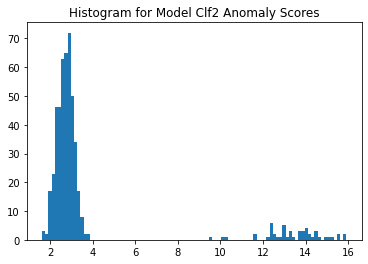

In [27]:
clf2 = AutoEncoder(hidden_neurons =[25, 10,2, 10, 25])
clf2.fit(X_train)

# Predict the anomaly scores
y_test_scores = clf2.decision_function(X_test)  
y_test_scores = pd.Series(y_test_scores)

# Plot the histogram
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf2 Anomaly Scores")
plt.show()

In [28]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,0.240887,0.260996,0.251000,0.255338,0.259391,0.236949,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,2.704472
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,-2.167980,-2.348960,-2.259004,-2.298042,-2.334521,-2.132539,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,13.393525


# Model 3— Step 1,2,3

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_13 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_14 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_15 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 15)               

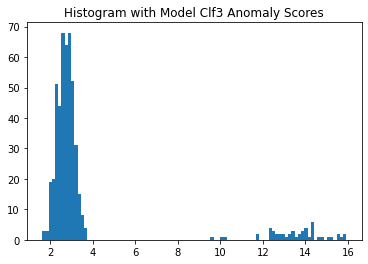

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,0.240887,0.260996,0.251000,0.255338,0.259391,0.236949,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,2.718697
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,-2.167980,-2.348960,-2.259004,-2.298042,-2.334521,-2.132539,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,13.488630


In [29]:
# Step 1: Build the model
clf3 = AutoEncoder(hidden_neurons =[25, 15, 10, 2, 10,15, 25])
clf3.fit(X_train)

# Predict the anomaly scores
y_test_scores = clf3.decision_function(X_test)  
y_test_scores = pd.Series(y_test_scores)

# Step 2: Determine the cut point
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram with Model Clf3 Anomaly Scores")
plt.show()

df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

# Step 3: Get the summary statistics by cluster
df_test.groupby('cluster').mean()

# Aggregate to Achieve Model Stability

You may wonder why I go with a great length to produce the three models. Here let me reveal the reason: Although unsupervised techniques are powerful in detecting outliers, they are prone to overfitting and unstable results. The solution is to train multiple models then aggregate the scores. In the aggregation process, you still will follow Step 2 and 3 like before.

## Average Method

In [30]:
# Put all the predictions in a data frame
from pyod.models.combination import aom, moa, average, maximization

# Put all the predictions in a data frame
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test),
                             'clf3': clf3.decision_function(X_test) 
                            })

In [31]:
train_scores

,clf1,clf2,clf3
0,2.581169,2.747950,2.760979
1,2.504626,2.666813,2.689774
2,2.634121,2.789920,2.799378
3,2.489325,2.590420,2.601639
4,2.227009,2.240596,2.257112
...,...,...,...
495,14.964735,14.099149,14.257848
496,15.537908,14.579711,14.842728
497,14.778036,14.067678,14.096280
498,13.327944,12.602299,12.655603


In [34]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
train_scores_norm = StandardScaler().fit_transform(train_scores)
test_scores_norm = StandardScaler().fit_transform(test_scores)

In [38]:
# Combination by average
y_by_average = average(test_scores_norm)

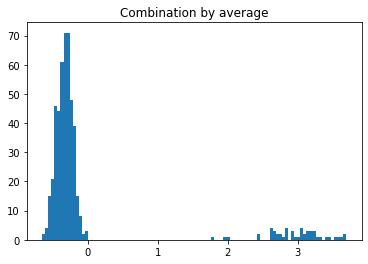

In [39]:
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

It appears we can identify those >=0.0 as the outliers. Our example identifies 50 outliers (not shown).

In [40]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<0, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    450
1     50
Name: y_by_average_cluster, dtype: int64

In [41]:
df_test.groupby('y_by_average_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,y_by_average_score
y_by_average_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,0.240887,0.260996,0.251000,0.255338,0.259391,0.236949,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,-0.328636
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,-2.167980,-2.348960,-2.259004,-2.298042,-2.334521,-2.132539,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,2.957725


## Maximum of Maximum Method

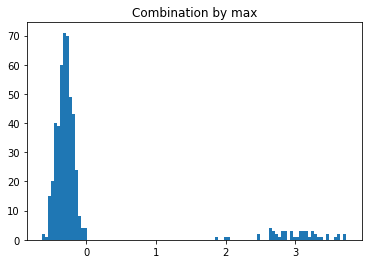

In [42]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [43]:
df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<0, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

0    450
1     50
Name: y_by_maximization_cluster, dtype: int64

In [44]:
df_test.groupby('y_by_maximization_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,y_by_average_score,y_by_average_cluster,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,0.240887,0.260996,0.251000,0.255338,0.259391,0.236949,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,-0.328636,0,-0.309781
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,-2.167980,-2.348960,-2.259004,-2.298042,-2.334521,-2.132539,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,2.957725,1,2.979374
